# Homework 5

### Garrick Hague

## Dataset Description

The training data consists of polarimetric radar parameters calculated from a disdrometer (an instrument that measures rain drop sizes, shapes, and rainfall rate) measurements from several years in Huntsville, Alabama. A model called `pytmatrix` is used to calculate polarimetric radar parameters from the droplet observations, which can be used as a way to compare what a remote sensing instrument would see and rainfall.

## Data columns

Features (radar measurements):

`Zh` - radar reflectivity factor (dBZ) - use the formula $dBZ = 10\log_{10}(Z)$

`Zdr` - differential reflectivity

Differential Reflectivity (ZDR) is a parameter commonly used in radar meteorology to describe the difference in the reflectivity of radar returns between horizontally and vertically polarized signals. It is calculated as the logarithm of the ratio of the reflectivity factors received in the horizontal and vertical polarizations:

In meteorological radar, ZDR provides valuable information about the shape and characteristics of hydrometeors (precipitation particles). Positive values of ZDR (greater than 0 dB) typically indicate that the hydrometeors are more horizontally oriented, such as raindrops, while negative values (less than 0 dB) indicate more vertically oriented hydrometeors, such as ice particles.

`Ldr` - linear depolarization ratio

LDR values close to 0 dB indicate minimal depolarization, meaning that the radar returns are predominantly co-polarized. Positive LDR values indicate a higher proportion of cross-polarized returns relative to co-polarized returns, suggesting significant depolarization.

Linear depolarization ratio is valuable for identifying and characterizing non-spherical or partially oriented scatterers, such as hail, ice crystals, or oriented precipitation particles. It can also provide information about the presence of atmospheric phenomena such as dust, smoke, or insects, which can exhibit significant depolarization effects.

`Kdp` - specific differential phase


Specific Differential Phase (KDP) is a parameter used in dual-polarization radar meteorology to measure the rate of change of the differential phase shift of the transmitted radar pulses as they interact with precipitation particles. It provides valuable information about the distribution of hydrometeors (precipitation particles) within the radar volume and their characteristics, such as size, shape, and orientation.

KDP is calculated as the derivative of the differential phase shift (ΦDP) with respect to range (distance from the radar), normalized by the radar wavelength.

`Ah` - specific attenuation


Specific Attenuation is a parameter used in radar meteorology to quantify the attenuation of radar signals as they propagate through the atmosphere due to the presence of hydrometeors (such as rain, snow, or hail). It describes the rate at which the radar signal's power decreases per unit distance traveled through the atmosphere.

`Adp` - differential attenuation

Target :

`R` - rain rate

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor




In [2]:
df = pd.read_csv('radar_parameters.csv', index_col=0)

In [3]:
df

,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr)
0,23.144878,0.418637,-41.757733,0.005395,0.000290,0.000012,2.393520
1,22.737156,0.322850,-43.772069,0.005194,0.000360,0.000012,3.502699
2,26.869826,0.330948,-43.577399,0.013385,0.000903,0.000030,8.627561
3,28.540561,0.399480,-42.139731,0.018872,0.001036,0.000043,8.424447
4,30.500127,0.543758,-39.763087,0.027438,0.001157,0.000064,8.189291
...,...,...,...,...,...,...,...
18964,31.515997,0.579955,-39.244229,0.034048,0.001417,0.000080,10.648020
18965,29.993334,0.567935,-39.399188,0.024134,0.001032,0.000057,7.981875
18966,31.685913,0.655681,-38.375696,0.033971,0.001165,0.000081,6.822691
18967,32.980096,0.768586,-37.166218,0.043117,0.001285,0.000105,6.801169


In [4]:
df.describe()

,Zh (dBZ),Zdr (dB),Ldr (dB),Kdp (deg km-1),Ah (dBZ/km),Adr (dB/km),R (mm/hr)
count,18969.000000,18969.000000,18969.000000,18969.000000,18969.000000,18969.000000,18969.000000
mean,31.294021,0.762979,-37.969272,0.080879,0.001829,0.000234,7.855561
std,6.496330,0.363489,3.277391,0.221018,0.003469,0.000822,8.569413
min,14.036426,0.285207,-44.849249,0.000697,0.000044,0.000002,0.309399
25%,26.720145,0.489184,-40.573505,0.011537,0.000482,0.000027,3.072614
50%,31.020280,0.677804,-38.113140,0.028640,0.000977,0.000069,5.622457
75%,35.597165,0.947020,-35.601404,0.073099,0.001970,0.000182,9.622175
max,57.400639,3.843941,-25.373718,5.060710,0.082511,0.027538,195.557062


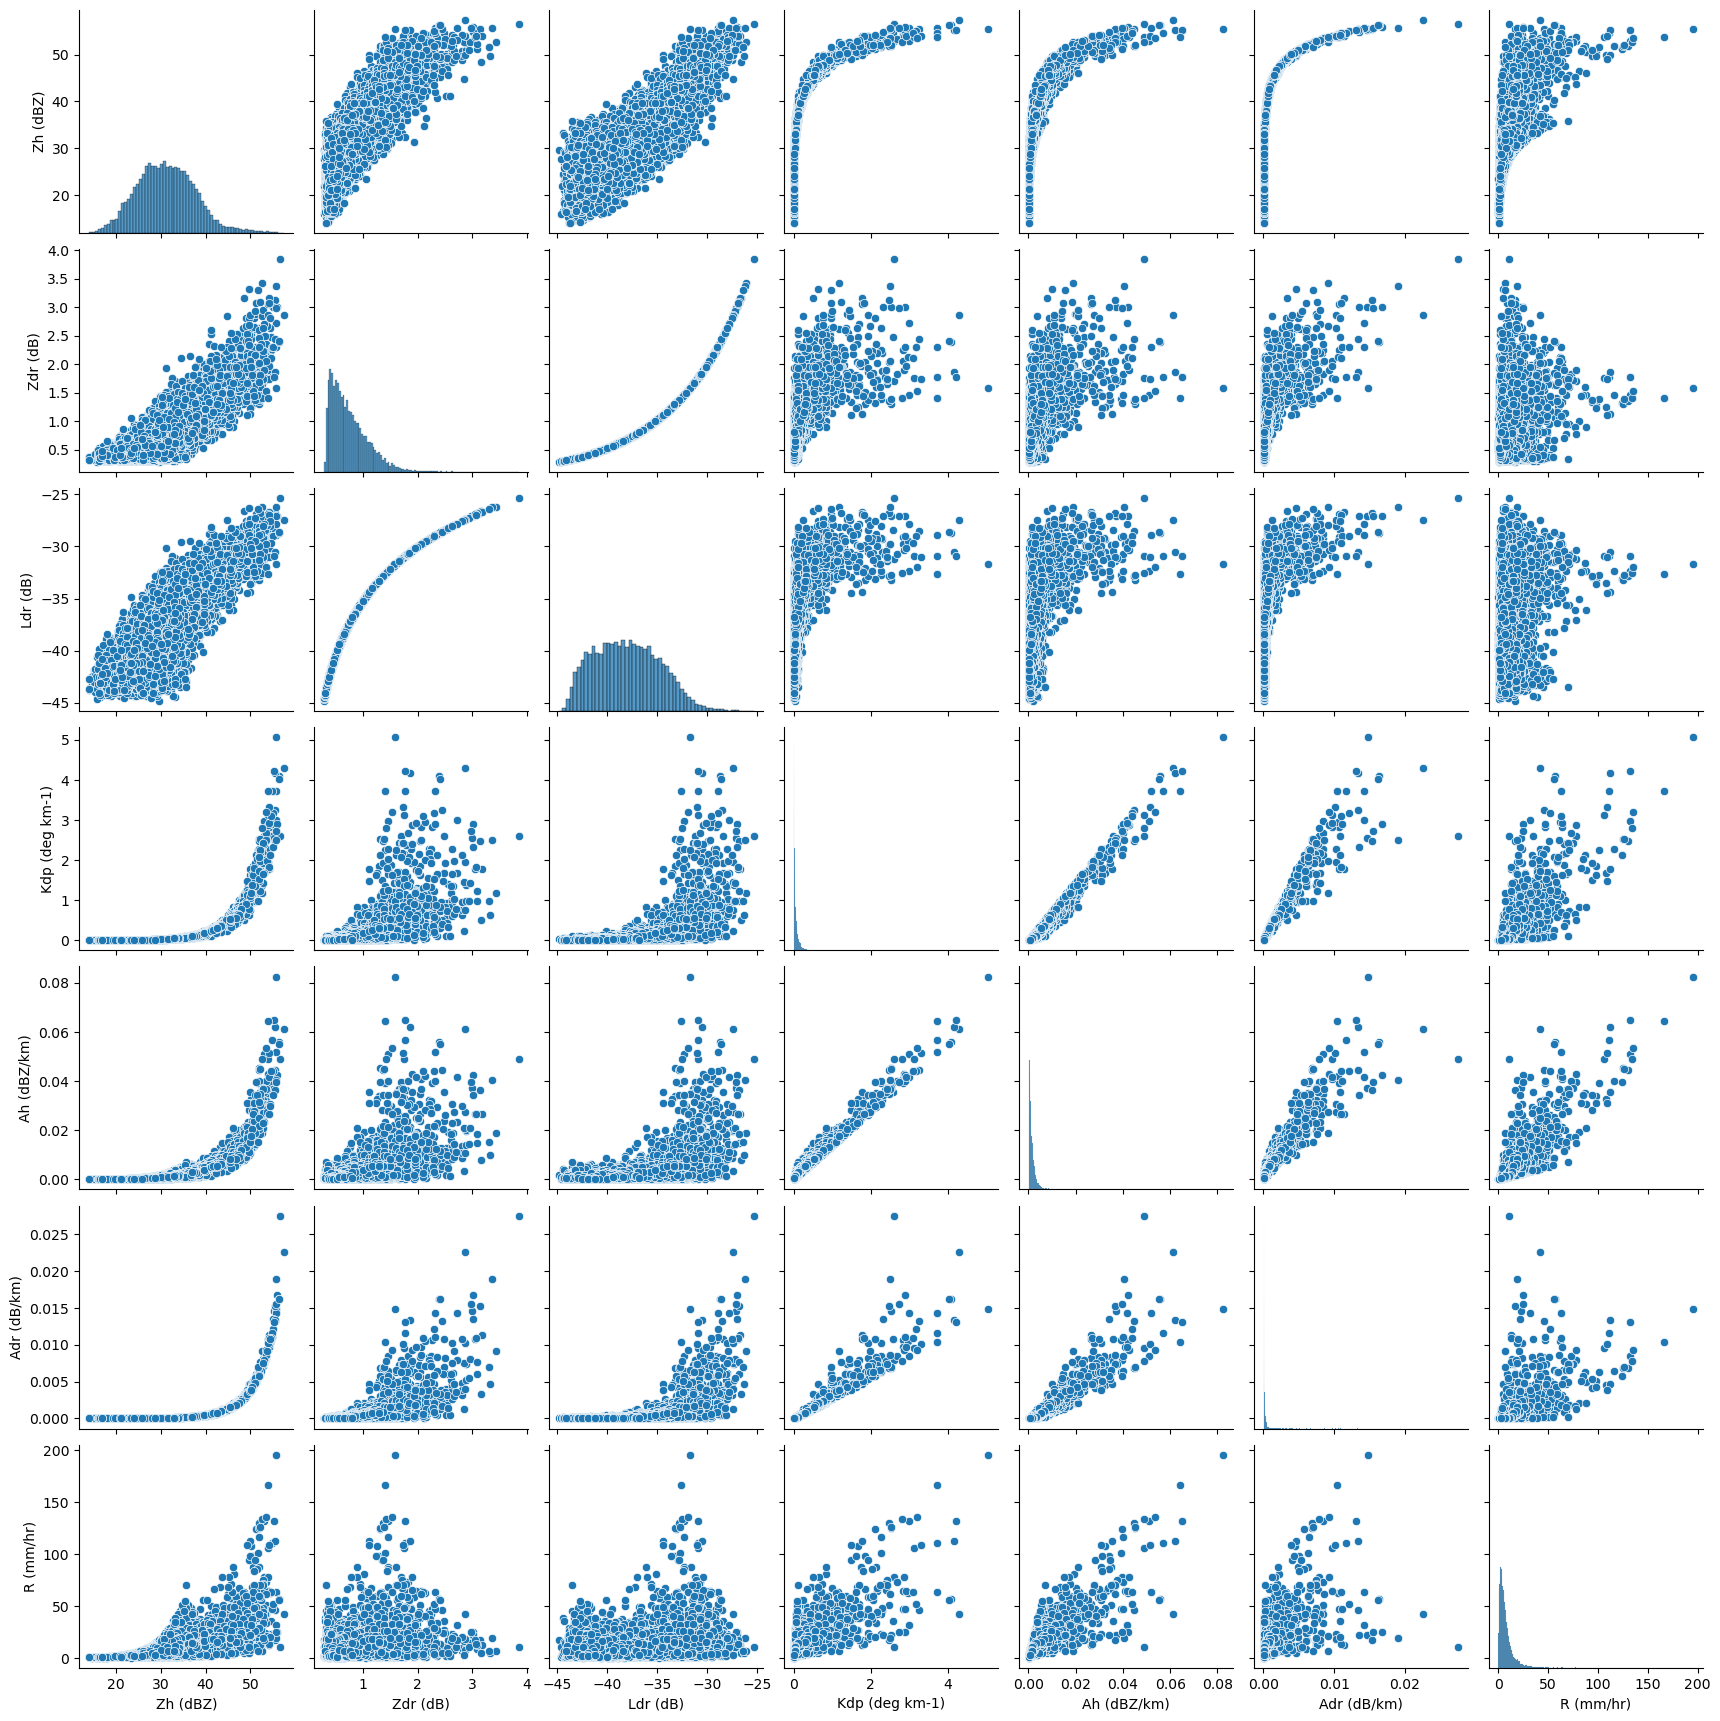

In [5]:
sns.pairplot(df)

# 1. Split the data into a 70-30 split for training and testing data.

In [6]:
# Define the features (X) and target variable (y)
X = df[['Zh (dBZ)', 'Zdr (dB)', 'Ldr (dB)', 'Kdp (deg km-1)', 'Ah (dBZ/km)', 'Adr (dB/km)']]
y = df['R (mm/hr)']

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. Using the split created in (1), train a multiple linear regression dataset using the training dataset, and validate it using the testing dataset.  Compare the $R^2$ and root mean square errors of model on the training and testing sets to a baseline prediction of rain rate using the formula $Z = 200 R^{1.6}$.

In [7]:
# Train a multiple linear regression model using the training dataset
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the trained model on testing datasets
y_test_pred = model.predict(X_test)

# Calculate R^2 for the model predictions on testing datasets
r2_test = r2_score(y_test, y_test_pred)

In [8]:
print(f'R^2 for test is: {r2_test}')

R^2 for test is: 0.9890992951689396


In [9]:
# Calculate RMSE for the model predictions on testing datasets
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

In [10]:
print(f'RMSE for test is: {rmse_test}')

RMSE for test is: 0.9358124742086995


In [11]:
# Calculate baseline predictions using the formula Z = 200 * R^1.6
baseline_train_pred = 200 * np.power(y_train, 1.6)
baseline_test_pred = 200 * np.power(y_test, 1.6)

# Calculate R^2 for the baseline predictions on both training and testing datasets
r2_baseline_train = r2_score(y_train, baseline_train_pred)
r2_baseline_test = r2_score(y_test, baseline_test_pred)

# Calculate RMSE for the baseline predictions on both training and testing datasets
rmse_baseline_train = np.sqrt(mean_squared_error(y_train, baseline_train_pred))
rmse_baseline_test = np.sqrt(mean_squared_error(y_test, baseline_test_pred))

In [12]:
print(f"           Baseline Prediction")
print("     -------------------------------------")
print(f"                  train               test")
print(f"  R^2     |    {r2_baseline_train:.2f}    |    {r2_baseline_test:.2f}")
print(f"  RMSE    |    {rmse_baseline_train:.2f}       |    {rmse_baseline_test:.2f}")

           Baseline Prediction
     -------------------------------------
                  train               test
  R^2     |    -6875917.31    |    -7216632.89
  RMSE    |    22008.97       |    24078.47


# 3. Repeat 1 doing a grid search over polynomial orders, using a grid search over orders 0-21, and use cross-validation of 7 folds.  For the best polynomial model in terms of $R^2$, does it outperform the baseline and the linear regression model in terms of $R^2$ and root mean square error?

In [13]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [14]:
param_grid = {'polynomialfeatures__degree': np.arange(3),
              'linearregression__fit_intercept': [True, False]}
              #'linearregression__normalize': [True, False]}

grid_search = GridSearchCV(PolynomialRegression(), param_grid, cv=7, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best polynomial model
best_poly_model = grid_search.best_estimator_


In [15]:
poly_predictions = best_poly_model.predict(X_test)
poly_r2 = r2_score(y_test, poly_predictions)
poly_rmse = np.sqrt(mean_squared_error(y_test, poly_predictions))

print("\nBaseline Regression Model:")
print(f'R^2: {r2_test}')
print(f'RMSE: {rmse_test}')

print("\nBest Polynomial Regression Model:")
print("R^2:", poly_r2)
print("RMSE:", poly_rmse)


Baseline Regression Model:
R^2 for test is: 0.9890992951689396
RMSE for test is: 0.9358124742086995

Best Polynomial Regression Model:
R^2: 0.9995805761885448
RMSE: 0.18356424028494475


# 4. Repeat 1 with a Random Forest Regressor, and perform a grid_search on the following parameters:
   
   ```python
   {'bootstrap': [True, False],  
   'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
   'max_features': ['auto', 'sqrt'],  
   'min_samples_leaf': [1, 2, 4],  
   'min_samples_split': [2, 5, 10],  
   'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
   ```
  Can you beat the baseline, or the linear regression, or best polynomial model with the best optimized Random Forest Regressor in terms of $R^2$ and root mean square error?

In [19]:
# Define parameter grid
param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# Create Random Forest
rf = RandomForestRegressor()

# Create GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Train the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

/Users/garrickhague/opt/anaconda3/envs/pythia/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/garrickhague/opt/anaconda3/envs/pythia/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/garrickhague/opt/anaconda3/envs/pythia/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/garrickhague/opt/anaconda3/envs/pythia/lib/python3.12/site-packages/sklearn

Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
